## Preprocessing Tasks

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv("201703_Taiwan.csv")

df.head()

,Date,Time,device_id,PM2.5,PM10,PM1,Temperature,Humidity,lat,lon
0,2017-03-01,08:00:00,74DA388FF5F6,41,48,28,20.00,89,25.059,121.499
1,2017-03-01,08:00:01,28C2DDDD4781,41,0,0,23.37,73,23.483,120.443
2,2017-03-01,08:00:01,74DA3895E132,52,66,35,25.50,60,22.624,120.356
3,2017-03-01,08:00:02,74DA3895C590,39,44,26,20.25,79,24.252,120.739
4,2017-03-01,08:00:02,74DA3895C34E,42,56,30,21.12,78,24.196,120.748


### drop 0 and NaN value

若某列有某項attribute是0值或NaN，則丟掉該列

In [3]:
droplist=[]
for attr in df.columns:
    for index, value in enumerate(df[attr]):
        if value == 0:
            droplist.append(index)            
df_n0 = df.drop(df.index[droplist])

df_n0 = df_n0.dropna(axis=0, how='any')
df_n0.head()

,Date,Time,device_id,PM2.5,PM10,PM1,Temperature,Humidity,lat,lon
0,2017-03-01,08:00:00,74DA388FF5F6,41,48,28,20.00,89,25.059,121.499
2,2017-03-01,08:00:01,74DA3895E132,52,66,35,25.50,60,22.624,120.356
3,2017-03-01,08:00:02,74DA3895C590,39,44,26,20.25,79,24.252,120.739
4,2017-03-01,08:00:02,74DA3895C34E,42,56,30,21.12,78,24.196,120.748
5,2017-03-01,08:00:02,74DA3895E12A,74,92,54,21.00,83,22.633,120.359


### remove few data & long time gap

#### 原有1211組sensor data
#### 移除2000筆以下的sensor data (剩下976組sensor data)
#### 移除8小時以上long time gap的sensor data (剩下756組sensor data)

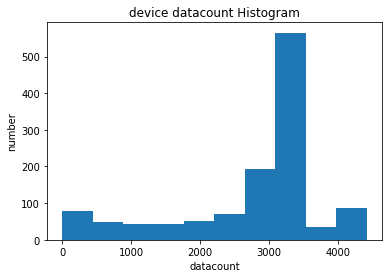

In [4]:
import matplotlib.pyplot as plt
import numpy as np


device_histagram_list = []
for device_id, df_device_id_region in df_n0.groupby("device_id"):
    device_histagram_list.append(df_device_id_region.shape[0])
    
plt.hist(device_histagram_list)
plt.title("device datacount Histogram")
plt.xlabel("datacount")
plt.ylabel("number")

plt.show()

In [5]:
device_id_list = {}
ori_count = 0
for device_id, df_device_id_region in df_n0.groupby("device_id"):
    ori_count += 1
    if df_device_id_region.shape[0]>2000:
        device_id_list[device_id] = df_device_id_region
        
print (ori_count)   
print ( len(device_id_list) )

1211
976


In [6]:
device_id_list2 = {}
for device_id, df_device_id_region in device_id_list.items():
#     print (df_device_id_region)
    time_c = pd.to_datetime(df_device_id_region['Time'])
    time_c = time_c.dt.hour + time_c.dt.minute/60
    
    keep_or_not= True
    last_time=0
    for time_value in time_c:
        last_time = time_value if last_time==0 else last_time
 
        if time_value - last_time > 8:
#             print (time_value)
#             print (last_time)
            keep_or_not = False
            break
        last_time = time_value

    if keep_or_not:
        device_id_list2[device_id] = df_device_id_region
        
print (len(device_id_list2))
    


756


### Data alignment

時間軸的align單位為每個整點。因此會先對某個整點的所有PM2.5取平均，作為該整點的值。若有某整點沒有可以參考的PM2.5值，則再使用內插法。


### Save new dataset 

以csv的方式，一個感測器資料存一個檔案。

In [7]:
i=0

sensor_list=[]

for device_id, df_device_id_region in device_id_list2.items():
    alignment_frame = df_device_id_region.drop(df_device_id_region.columns[[4,5,6,7]], axis=1)
    
    time_c = pd.to_datetime(alignment_frame['Time'])
    time_c_begin = time_c.dt.hour[time_c.dt.hour.index[0]]
    
    row_list=[]
    for row in range(alignment_frame.shape[0]):
        if row in row_list:
            continue
        pm25_list=[]
        now_time = time_c.dt.hour[time_c.dt.hour.index[row]]
        alignment_frame.loc[alignment_frame.index[row],['Time']]=now_time
        
        tmp = row
        tmp_row_list=[]
        while now_time == time_c_begin:
            try: 
                pm25_list.append(alignment_frame.loc[alignment_frame.index[tmp],['PM2.5']])
                tmp_row_list.append(tmp)
                tmp=tmp+1
                now_time = time_c.dt.hour[time_c.dt.hour.index[tmp]]
            except:
                break
                
        if tmp_row_list[1:] != []:
            row_list.extend(tmp_row_list[1:])

        if pm25_list != []:
            try:
                avg_pm25 = ( sum(pm25_list)/len(pm25_list))
                alignment_frame.loc[alignment_frame.index[row],['PM2.5']] = avg_pm25[0]
                time_c_begin = now_time
            except:
                break
    alignment_frame = alignment_frame.drop(alignment_frame.index[row_list], axis=0)
    
    
    for row in range(alignment_frame.shape[0]-1):
        now_time = alignment_frame.loc[alignment_frame.index[row],['Time']]
        next_time = alignment_frame.loc[alignment_frame.index[row+1],['Time']]
        
        count = next_time-now_time
        
        if int(count) != 1 and int(count) != -23:
            now_PM25 = alignment_frame.loc[alignment_frame.index[row],['PM2.5']]
            next_PM25 = alignment_frame.loc[alignment_frame.index[row+1],['PM2.5']]
            
            now_PM25= np.array(now_PM25)
            next_PM25= np.array(next_PM25)
            count = np.array(count)
            
            alignment_frame.loc[alignment_frame.index[row]+1,['PM2.5']] = ((now_PM25+next_PM25)/count)[0]
            alignment_frame.loc[alignment_frame.index[row]+1,['Date']] = alignment_frame.loc[alignment_frame.index[row],['Date']][0]
            alignment_frame.loc[alignment_frame.index[row]+1,['Time']] = alignment_frame.loc[alignment_frame.index[row],['Time']][0]+1
    
    alignment_frame.index = alignment_frame.index+1
    alignment_frame = alignment_frame.sort_index()

    alignment_frame.to_csv('sensor_%s' %device_id)
    
    sensor_list.append(device_id)
    
    i += 1
    if i==2:
        break

## Observation Tasks

### Compare sensors

此部分的device_id, lat, lon有NaN，是因為這些資料是由內插法補上的。
因為是同一個感測器，id, lat, lon理應相同，所以先讓它保留NaN。

Sensor1=74DA3895E03E, Sensor2=74DA3895E004

In [8]:
sensor1 = pd.read_csv("sensor_74DA3895E03E")

sensor1_2017_03_10 = sensor1.loc[sensor1['Date'] == '2017-03-10']

sensor1_2017_03_10

,Unnamed: 0,Date,Time,device_id,PM2.5,lat,lon
208,939128,2017-03-10,0,74DA3895E03E,78.500000,22.853,120.546
209,944147,2017-03-10,1,74DA3895E03E,76.500000,22.853,120.546
210,949581,2017-03-10,2,74DA3895E03E,75.000000,22.853,120.546
211,953836,2017-03-10,3,74DA3895E03E,77.333333,22.853,120.546
212,957928,2017-03-10,4,74DA3895E03E,77.857143,22.853,120.546
213,963022,2017-03-10,5,74DA3895E03E,75.250000,22.853,120.546
214,971339,2017-03-10,6,74DA3895E03E,68.000000,22.853,120.546
215,973577,2017-03-10,7,74DA3895E03E,63.000000,22.853,120.546
216,974921,2017-03-10,8,74DA3895E03E,66.000000,22.853,120.546
217,976068,2017-03-10,9,74DA3895E03E,67.000000,22.853,120.546


In [9]:
sensor2 = pd.read_csv("sensor_74DA3895E004")

sensor2.head()

sensor2_2017_03_10 = sensor2.loc[sensor2['Date'] == '2017-03-10']

sensor2_2017_03_10

,Unnamed: 0,Date,Time,device_id,PM2.5,lat,lon
208,939802,2017-03-10,0,74DA3895E004,93.000000,23.012,120.217
209,944832,2017-03-10,1,74DA3895E004,86.000000,23.012,120.217
210,949905,2017-03-10,2,74DA3895E004,86.750000,23.012,120.217
211,954984,2017-03-10,3,74DA3895E004,97.000000,23.012,120.217
212,960073,2017-03-10,4,74DA3895E004,98.500000,23.012,120.217
213,966153,2017-03-10,5,74DA3895E004,105.000000,23.012,120.217
214,967089,2017-03-10,6,74DA3895E004,103.666667,23.012,120.217
215,972639,2017-03-10,7,74DA3895E004,92.000000,23.012,120.217
216,975471,2017-03-10,8,74DA3895E004,82.000000,23.012,120.217
217,976332,2017-03-10,9,74DA3895E004,65.500000,23.012,120.217


### Interested Observation

可觀察到sensor1跟sensro2有相同的趨勢，在晚上凌晨會有較高的PM2.5值，白天則趨緩。不過一個sensor是約在傍晚升上高峰，另一個則是晚上，或許是這兩地下班車潮不同的關係?

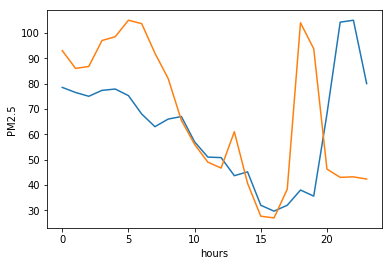

In [10]:
import matplotlib.pyplot as plt

s1PM25 = np.array(sensor1_2017_03_10['PM2.5'])
s2PM25 = np.array(sensor2_2017_03_10['PM2.5'])
time = np.array(sensor1_2017_03_10['Time'])

plt.plot(time,s1PM25,time, s2PM25)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()


### Plot sensor map

In [11]:
sensor_gps = pd.DataFrame(columns=['lat','lon'])
for device_id, df_device_id_region in device_id_list2.items():

    lat = df_device_id_region.loc[df_device_id_region.index[0],[' lat']]
    lon = df_device_id_region.loc[df_device_id_region.index[0],[' lon']]
    
    lat = lat.values[0]
    lon = lon.values[0]

    sensor_gps.loc[device_id] = [lat,lon]

sensor_gps.to_csv('sensor_gps', index=False)

![title](gps.PNG "ShowMyImage")

### Query Tasks (此部分回答以Data Preprocessing後的資料為主)

1. 1211組sensor (可由Data Preprocessing中觀察)
2. 記錄到3月份最高溫的是74DA3895DFB2，溫度是52.25，位於lat:22.669 lon:120.3 (高雄瑞豐夜市附近)
3. 如下列cell的output所示，因部分感測器無3/5號PM2.5(也沒有3/5號附近的資料，內插法誤差大)，故顯示NaN
4. 感測器位置主要落於台灣，有部分在日本、韓國、馬來西亞甚至美國。

In [12]:
max_temp = 0
sen_lat = 0
sen_lon = 0
sen_tem_id = ''

columns=['device_id', 'PM2.5']
sensor_PM25= pd.DataFrame(columns=columns)

index=0
for device_id, df_device_id_region in device_id_list2.items():
    
    if df_device_id_region['Temperature'].values.max() > max_temp:
        max_temp = df_device_id_region['Temperature'].values.max()
        sen_lat = df_device_id_region[' lat'].values[0]
        sen_lon = df_device_id_region[' lon'].values[0]
        sen_tem_id = df_device_id_region['device_id'].values[0]
        
    
    sensor_PM25.loc[index] = [device_id, df_device_id_region.loc[df_device_id_region['Date'] == '2017-03-05']['PM2.5'].max()]
    
    index=index+1    

print (max_temp)
print (sen_lat)
print (sen_lon)
print (sen_tem_id)

print (sensor_PM25) 

52.25
22.669
120.3
74DA3895DFB2
        device_id PM2.5
0    74DA3895DF44   246
1    74DA3895C5C4   118
2    74DA3895DE9E    57
3    74DA3895DE04    79
4    74DA3895C578   112
5    74DA38AF48CA    51
6    74DA38AF478C    38
7    74DA38AF483E    43
8    74DA38AF4798    76
9    74DA3895DEF0    76
10   74DA3895DDF2    64
11   74DA3895DE3A    83
12   74DA3895DDFE   125
13   74DA3895DF64    84
14   74DA3895DFFC    74
15   74DA38B7933E   NaN
16   74DA3895E11A    80
17   74DA3895DE94    82
18   74DA3895C5D0    69
19   74DA3895DF94    60
20   74DA3895DF5E    70
21   74DA3895DF1A   183
22   74DA3895E016    46
23   74DA3895E140   NaN
24   74DA3895C39A    84
25   74DA3895C2CC    96
26   74DA38B0530E   NaN
27   74DA3895E000    55
28   74DA3895DE6C   100
29   74DA3895C216    90
..            ...   ...
726  74DA3895DE1C   106
727  74DA38AF47E6   NaN
728  74DA3895DEAC    87
729  74DA38A86950    37
730  74DA3895E194   207
731  74DA3895C210    88
732  74DA3895E188    93
733  74DA3895C396   176
734  74D

## Time Series Data Comparsion Tasks

選用同Observation的那兩支sensor，資料亦為2017-3-10這天的PM2.5

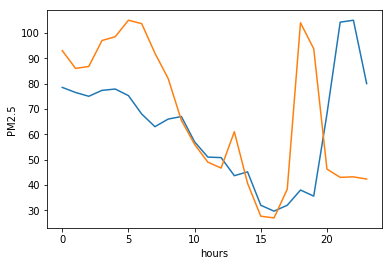

Euclidean_distance= 148.71696475713847


In [13]:
from math import sqrt
def euclidean_distance(A,B):
    return sqrt( sum (  (a-b)**2 for a,b in zip(A,B)  ) )


Q = sensor1.loc[sensor1['Date'] == '2017-03-10']['PM2.5']
C = sensor2.loc[sensor2['Date'] == '2017-03-10']['PM2.5']

Q_ori = np.array(Q)
C_ori = np.array(C)
time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_ori, time, C_ori)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_ori ,C_ori))

### Offset Translation

兩條線的距離變近了一點

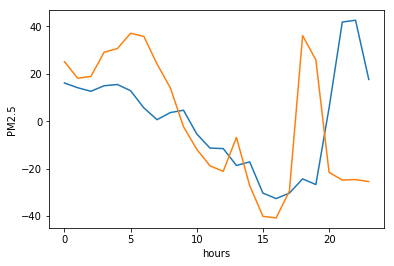

Euclidean_distance= 146.26725623770773


In [14]:
def offset_translation(sequence):
    mean = sum(sequence)/len(sequence)
    return sequence-mean

Q_offset = np.array(offset_translation(Q))
C_offset = np.array(offset_translation(C))

time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_offset, time, C_offset)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_offset ,C_offset))

### Amplitude Scaling

距離明顯下降

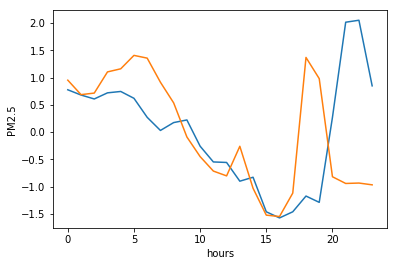

Euclidean_distance= 6.125405142709108


In [15]:
from sklearn.preprocessing import StandardScaler

def amplitude_scaling(sequence):
    mean = sum(sequence)/len(sequence)
    std = np.std(sequence)
    return (sequence-mean)/std

Q_amplitude = np.array(amplitude_scaling(Q))
C_amplitude = np.array(amplitude_scaling(C))

time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_amplitude, time, C_amplitude)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_amplitude ,C_amplitude))

### Linear Trend Removal

距離比原來降了18

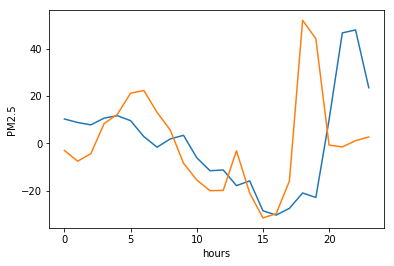

Euclidean_distance= 130.6034062199002


In [16]:
from sklearn import datasets, linear_model
def linear_trend_removel(sequence):
    regr = linear_model.LinearRegression()
    x = np.arange(24)[:,np.newaxis]
    y = np.array(sequence)[:,np.newaxis]
    regr.fit( x, y)
    line =  np.array(list( map(lambda x: regr.predict(x), np.arange(24)) ))[:,0,0]
    return sequence - line
    
Q_linear_tr = np.array(linear_trend_removel(Q))
C_linear_tr = np.array(linear_trend_removel(C))

time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_linear_tr, time, C_linear_tr)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_linear_tr ,C_linear_tr))

### Noise Removal

avg with left and right neighbor

距離比原來降了24

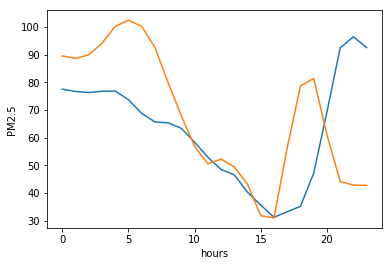

Euclidean_distance= 124.40368418813713


In [17]:
def noise_removal(sequence):
    sequence = np.array(sequence)
    new_sequence = []
    for index, number in enumerate(sequence):
        if index == 0:
            new_sequence.append( (number+sequence[index+1])/2 )
        elif index == len(sequence)-1:
            new_sequence.append( (number+sequence[index-1])/2 )
        else:
            new_sequence.append((number+sequence[index+1]+sequence[index-1])/3 ) 
    return new_sequence

Q_noise_removal = np.array(noise_removal(Q))
C_noise_removal = np.array(noise_removal(C))


time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_noise_removal, time, C_noise_removal)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_noise_removal ,C_noise_removal))

### Amplitude Scaling + Linear Trend Removal + Noise Removal

得到最低的4.5

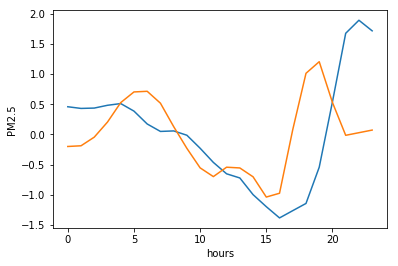

Euclidean_distance= 4.568454860041959


In [18]:
Q_final = np.array(noise_removal(linear_trend_removel(amplitude_scaling(Q))))
C_final = np.array(noise_removal(linear_trend_removel(amplitude_scaling(C))))


time = np.array(sensor1.loc[sensor1['Date'] == '2017-03-10']['Time'])

plt.plot(time, Q_final, time, C_final)
plt.xlabel('hours')
plt.ylabel('PM2.5')

plt.show()

print ("Euclidean_distance= %s" %euclidean_distance(Q_final ,C_final))